## Step 0 - Imports

In [17]:
import networkx as nx
nx.__version__

'2.1'

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue

%matplotlib inline

## Step 1 - Load Data

In [19]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points

In [20]:
from sampling import Sampler
sampler = Sampler(data)
polygons = sampler.polygons

nodes = sampler.sample(500)
print(len(nodes))

337


## Step 3 - Connect Nodes

In [21]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!
    
import numpy.linalg as LA
from sklearn.neighbors import KDTree

def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2):
                g.add_edge(n1, n2, weight=1)
    return g

import time
t0 = time.time()
g = create_graph(nodes, 10)
print('graph took {0} seconds to build'.format(time.time()-t0))
print("Number of edges", len(g.edges))


graph took 56.6065673828125 seconds to build
Number of edges 1014


## Step 4 - Visualize Graph

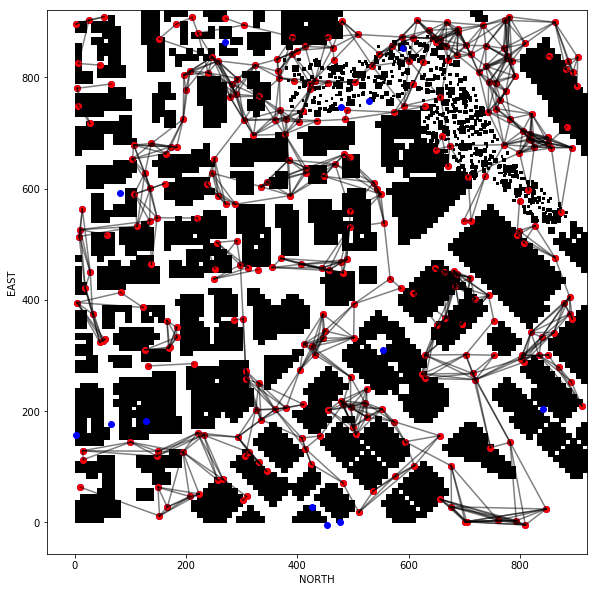

...done


In [30]:
# Create a grid map of the world
from planning_utils import heuristic, create_grid
# This will create a grid map at 1 m above ground level
grid, north_offset, east_offset = create_grid(data, 1, 1)

fig = plt.figure(figsize=(10,10))

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

print("...done")

## Step 6 - A*

In [25]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]

path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

276 324
Found a path.
8 [(53.149411687401425, -153.91858001882298, 2.771547866937145), (55.42615361249045, -136.79778362902226, 6.152565984391504), (-53.2259171495927, -131.41898641274202, 11.039235074005063), (-104.808681419934, -59.557068175165625, 10.767088105046996), (-36.46545250680208, -34.79668549276778, 14.135833488682897), (33.80184881811243, 9.658793900159935, 17.408844559352925), (82.46053667746213, 62.80697279864154, 17.985947457793078), (127.7990911201087, 127.43608750720387, 4.538738053946205)]
(53.149411687401425, -153.91858001882298, 2.771547866937145) (55.42615361249045, -136.79778362902226, 6.152565984391504)
(55.42615361249045, -136.79778362902226, 6.152565984391504) (-53.2259171495927, -131.41898641274202, 11.039235074005063)
(-53.2259171495927, -131.41898641274202, 11.039235074005063) (-104.808681419934, -59.557068175165625, 10.767088105046996)
(-104.808681419934, -59.557068175165625, 10.767088105046996) (-36.46545250680208, -34.79668549276778, 14.135833488682897)


## Step 7  - Visualize Path

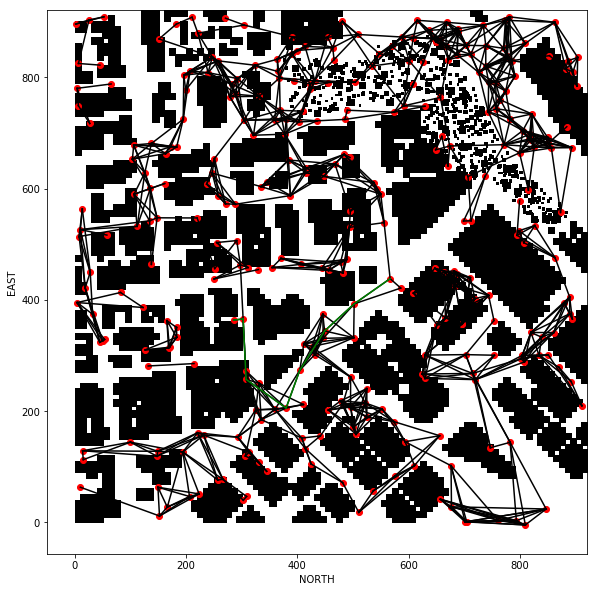

...done


In [29]:
fig = plt.figure(figsize=(10,10))

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

print("...done")